In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
url_base = 'http://localhost:3000/query2'

data_inicio = '01.01.2014'
data_final = '31.12.2023'

empresas = [
    {'Simbolo': 'Airbus', 'Ramo': 'Aviacao'},
    {'Simbolo': 'Air Canada', 'Ramo': 'Aviacao'},
    {'Simbolo': 'Air China', 'Ramo': 'Aviacao'},
    {'Simbolo': 'Apple', 'Ramo': 'Tecnologia'},
    {'Simbolo': 'Amazon', 'Ramo': 'Tecnologia'},
    
]

empresas_por_ramo = {}
for empresa in empresas:
    ramo = empresa['Ramo']
    simbolo = empresa['Simbolo']
    empresas_por_ramo.setdefault(ramo, []).append(simbolo)

print(empresas_por_ramo)


In [ ]:
lista_dfs = []

for ramo, simbolos in empresas_por_ramo.items():
    params = {
        'ramo': ramo,
        'simbolos': ','.join(simbolos),  # Enviar símbolos separados por vírgula
        'data_inicio': data_inicio,
        'data_final': data_final
    }
    response = requests.get(url_base, params=params)
    if response.status_code == 200:
        data = response.json()
        df_ramo = pd.DataFrame(data)
        # Converter 'Data' e 'Fechamento'
        df_ramo['Data'] = pd.to_datetime(df_ramo['Data'], format='%d.%m.%Y')
        df_ramo['Fechamento'] = pd.to_numeric(df_ramo['Fechamento'], errors='coerce')
        lista_dfs.append(df_ramo)
    else:
        print(f"Erro ao buscar dados para o ramo {ramo}: {response.text}")

# Concatenar todos os DataFrames
df = pd.concat(lista_dfs, ignore_index=True)
df.dropna(subset=['Fechamento'], inplace=True)
df.head()


In [ ]:
simbolos = ['Airbus', 'Air Canada', 'Air China', 'Apple', 'Amazon']

for simbolo in simbolos:
    df_simbolo = df[df['Simbolo'] == simbolo]
    plt.figure(figsize=(10, 5))
    plt.plot(df_simbolo['Data'], df_simbolo['Fechamento'], label=simbolo)
    plt.xlabel('Data')
    plt.ylabel('Fechamento')
    plt.title(f'Fechamento ao longo do tempo para {simbolo}')
    plt.legend()
    plt.show()

In [ ]:
# Selecionar os dados da empresa específica
empresa_especifica = 'Amazon'
df_empresa = df[df['Simbolo'] == empresa_especifica]

# Preparar os dados
fechamento = df_empresa['Fechamento'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
fechamento_scaled = scaler.fit_transform(fechamento)

# Criar sequências de dados para o LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Usar 60 dias de dados para prever o próximo dia
X, y = create_sequences(fechamento_scaled, seq_length)

# Dividir os dados em treino e teste
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# Célula 8: Fazer previsões
predictions = []
current_batch = fechamento_scaled[-seq_length:].reshape((1, seq_length, 1))

for _ in range(1825):
    pred = model.predict(current_batch)[0]
    predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

# Inverter a escala das previsões
predictions = scaler.inverse_transform(predictions)

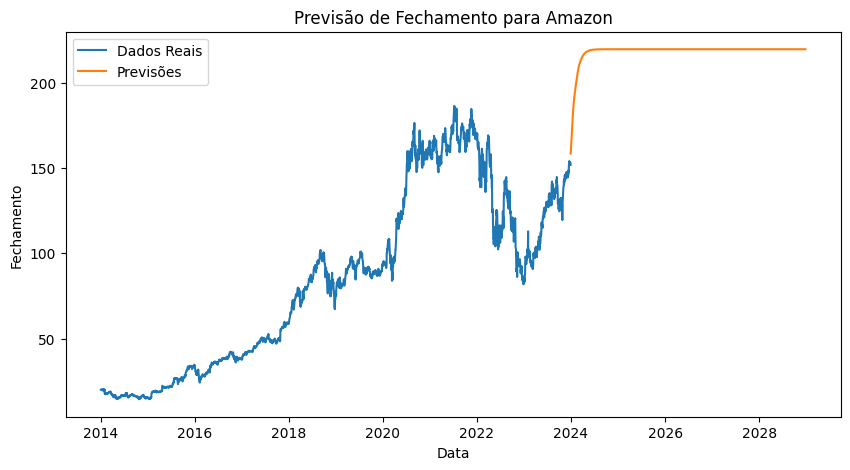

In [88]:
# Célula 9: Plotar previsões
plt.figure(figsize=(10, 5))
plt.plot(df_empresa['Data'], df_empresa['Fechamento'], label='Dados Reais')
future_dates = pd.date_range(start=df_empresa['Data'].iloc[-1], periods=1825, freq='D')
plt.plot(future_dates, predictions, label='Previsões')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.title(f'Previsão de Fechamento para {empresa_especifica}')
plt.legend()
plt.show()
